In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, OneHotEncoder

In [2]:
!pip install statsmodels


In [3]:
db_file = '/content/drive/MyDrive/Lung_cancer/lung_cancer.db'
conn = sqlite3.connect(db_file)
df = pd.read_sql("select * from lung_cancer", conn)

In [4]:
unique_counts = df.nunique()

# Check for any null values in all columns
null_values = df.isnull().any()

# Print the results
print("Unique Value Counts for Each Column:")
print(unique_counts)
print("\nAny Null Values in Columns:")
print(null_values)

Unique Value Counts for Each Column:
ID                        9998
Age                        157
Gender                       5
COPD History                 2
Genetic Markers              2
Air Pollution Exposure       3
Last Weight                 56
Current Weight              80
Start Smoking               97
Stop Smoking                84
Taken Bronchodilators        2
Frequency of Tiredness       3
Dominant Hand                3
Lung Cancer Occurrence       2
dtype: int64

Any Null Values in Columns:
ID                        False
Age                       False
Gender                    False
COPD History               True
Genetic Markers           False
Air Pollution Exposure     True
Last Weight               False
Current Weight            False
Start Smoking             False
Stop Smoking              False
Taken Bronchodilators      True
Frequency of Tiredness    False
Dominant Hand             False
Lung Cancer Occurrence    False
dtype: bool


In [5]:
null_counts = df.isnull().sum()

print(null_counts)

ID                           0
Age                          0
Gender                       0
COPD History              1112
Genetic Markers              0
Air Pollution Exposure       3
Last Weight                  0
Current Weight               0
Start Smoking                0
Stop Smoking                 0
Taken Bronchodilators     1061
Frequency of Tiredness       0
Dominant Hand                0
Lung Cancer Occurrence       0
dtype: int64


In [6]:
df['COPD History'].value_counts()

Yes    5691
No     3545
Name: COPD History, dtype: int64

In [7]:
df['Air Pollution Exposure'].value_counts()

High      6283
Low       2412
Medium    1650
Name: Air Pollution Exposure, dtype: int64

In [8]:
df['Taken Bronchodilators'].value_counts()

Yes    5742
No     3545
Name: Taken Bronchodilators, dtype: int64

In [9]:
duplicates = df[df.duplicated('ID', keep=False)]

# Sort the DataFrame based on 'ID' to examine duplicates more easily
duplicates_sorted = duplicates.sort_values(by='ID')

# Print the sorted DataFrame with duplicates
print("Duplicate Patient ID Records:")
print(duplicates_sorted.iloc[0])


Duplicate Patient ID Records:
ID                        9360174299016192.0
Age                                       65
Gender                                  Male
COPD History                             Yes
Genetic Markers                      Present
Air Pollution Exposure                   Low
Last Weight                               85
Current Weight                            84
Start Smoking                           1995
Stop Smoking                            2022
Taken Bronchodilators                   None
Frequency of Tiredness            None / Low
Dominant Hand                      RightBoth
Lung Cancer Occurrence                     0
Name: 1271, dtype: object


In [ ]:
df[df['ID'] == duplicates_sorted.iloc[0]['ID']]

,ID,Age,Gender,COPD History,Genetic Markers,Air Pollution Exposure,Last Weight,Current Weight,Start Smoking,Stop Smoking,Taken Bronchodilators,Frequency of Tiredness,Dominant Hand,Lung Cancer Occurrence
1271,9.360174e+15,65,Male,Yes,Present,Low,85,84,1995,2022,None,None / Low,RightBoth,0
10275,9.360174e+15,65,Male,Yes,Present,Low,85,84,1995,2022,None,None / Low,RightBoth,0


In [44]:
df_cleaned = df.drop_duplicates()
print(len(df_cleaned))
print(df_cleaned.nunique())

9998
ID                        9998
Age                        157
Gender                       5
COPD History                 2
Genetic Markers              2
Air Pollution Exposure       3
Last Weight                 56
Current Weight              80
Start Smoking               97
Stop Smoking                84
Taken Bronchodilators        2
Frequency of Tiredness       3
Dominant Hand                3
Lung Cancer Occurrence       2
dtype: int64


In [45]:
df_cleaned = df_cleaned.drop(columns=['ID']) # no need of ID column here

In [12]:
df_cleaned.isnull().sum()

Age                          0
Gender                       0
COPD History              1081
Genetic Markers              0
Air Pollution Exposure       3
Last Weight                  0
Current Weight               0
Start Smoking                0
Stop Smoking                 0
Taken Bronchodilators     1027
Frequency of Tiredness       0
Dominant Hand                0
Lung Cancer Occurrence       0
dtype: int64

In [13]:
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['Gender', 'COPD History', 'Genetic Markers', 'Air Pollution Exposure',
       'Start Smoking', 'Stop Smoking', 'Taken Bronchodilators',
       'Frequency of Tiredness', 'Dominant Hand'],
      dtype='object')


In [14]:
def plot_unique_value_counts_by_colname(dataframe, colname):

    plt.figure(figsize=(10, 4))
    dataframe[colname].value_counts(dropna=False).plot(kind='bar')
    plt.title(f'Unique value counts for {colname}')
    plt.ylabel('Counts')
    plt.xlabel('Values')
    plt.show()

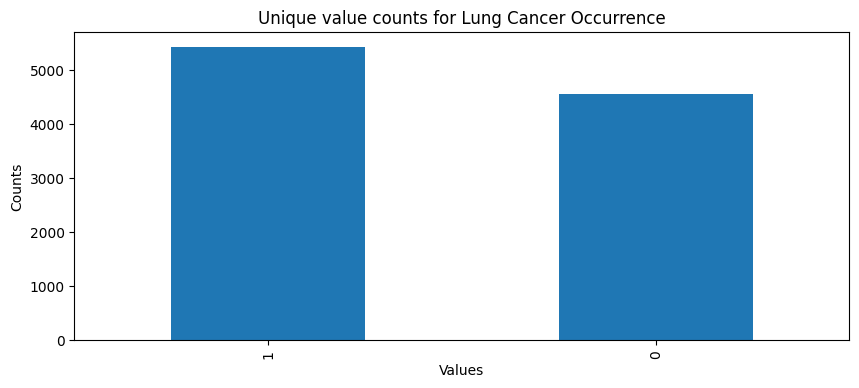

In [15]:
plot_unique_value_counts_by_colname(df_cleaned, 'Lung Cancer Occurrence')

In [46]:
from sklearn.impute import SimpleImputer

def custom_cat_imputation(column, strategy='most_frequent', fill_value='missing'):
    imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
    return pd.Series(imputer.fit_transform(column.values.reshape(-1, 1)).ravel())

# Impute categorical columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_cleaned[col] = custom_cat_imputation(df_cleaned[col])


df_cleaned[categorical_cols] = df_cleaned[categorical_cols].astype(str)

# Re-checking for missing values after imputation
rechecked_missing_values = df_cleaned.isnull().sum()

# Displaying the results after imputation
print(rechecked_missing_values)

Age                       0
Gender                    0
COPD History              0
Genetic Markers           0
Air Pollution Exposure    0
Last Weight               0
Current Weight            0
Start Smoking             0
Stop Smoking              0
Taken Bronchodilators     0
Frequency of Tiredness    0
Dominant Hand             0
Lung Cancer Occurrence    0
dtype: int64


In [17]:
numerical_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

In [18]:
numerical_cols

Index(['Age', 'Last Weight', 'Current Weight', 'Lung Cancer Occurrence'], dtype='object')

In [19]:
numerical_cols = numerical_cols.drop('Lung Cancer Occurrence')

In [20]:
target = 'Lung Cancer Occurrence'

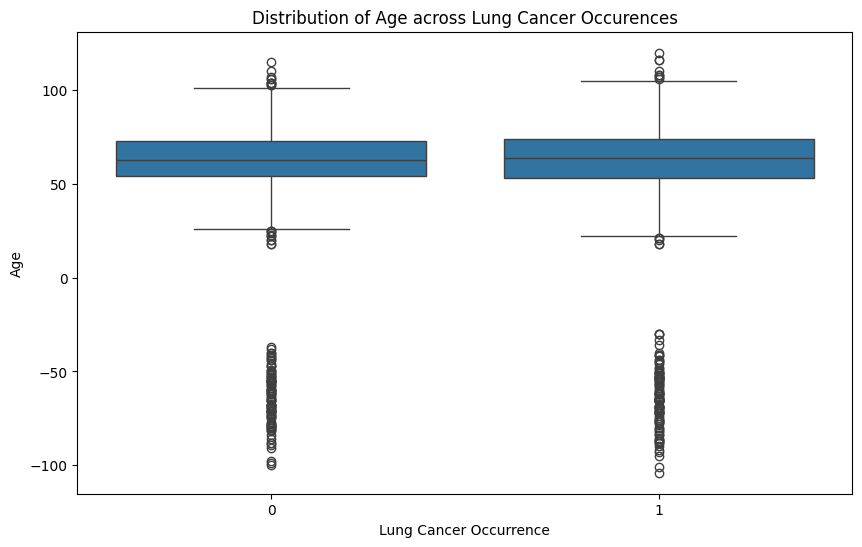

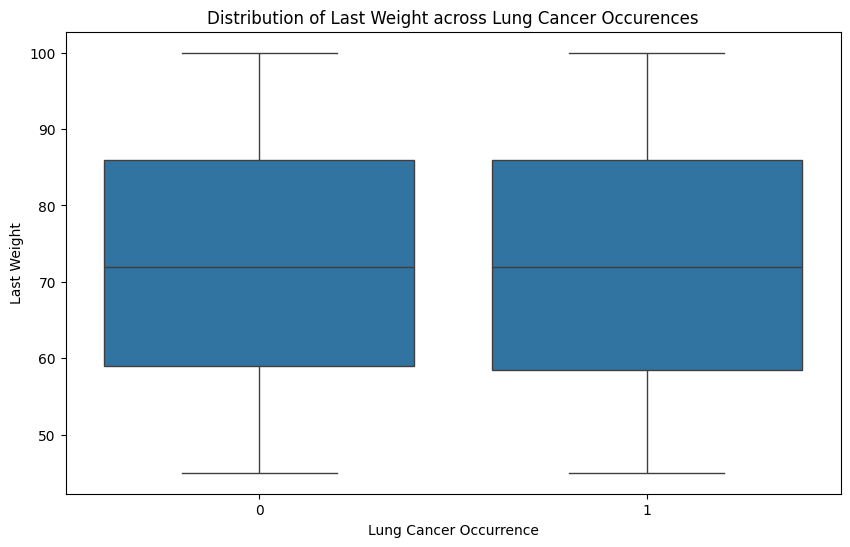

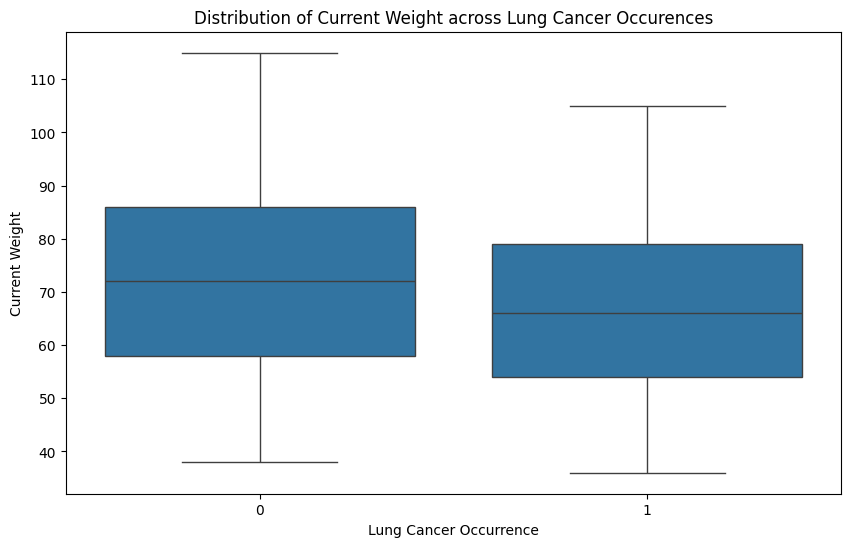

In [21]:
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_cleaned, x=target, y=col)
    plt.title(f'Distribution of {col} across Lung Cancer Occurences')
    plt.xlabel(target)
    plt.ylabel(col)
    plt.show()

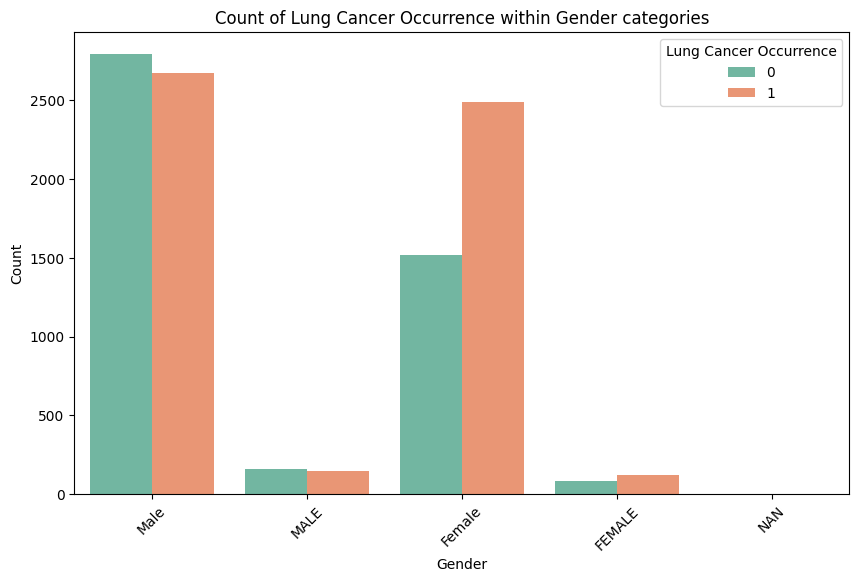

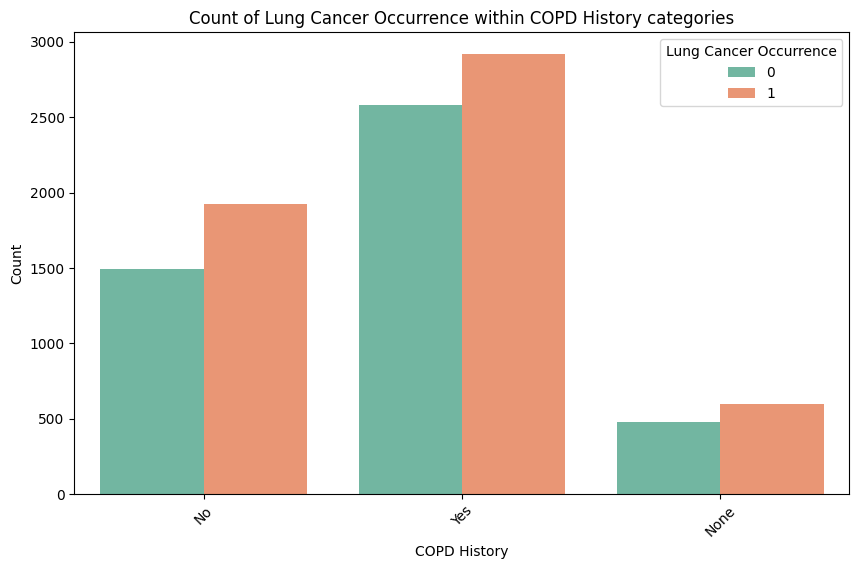

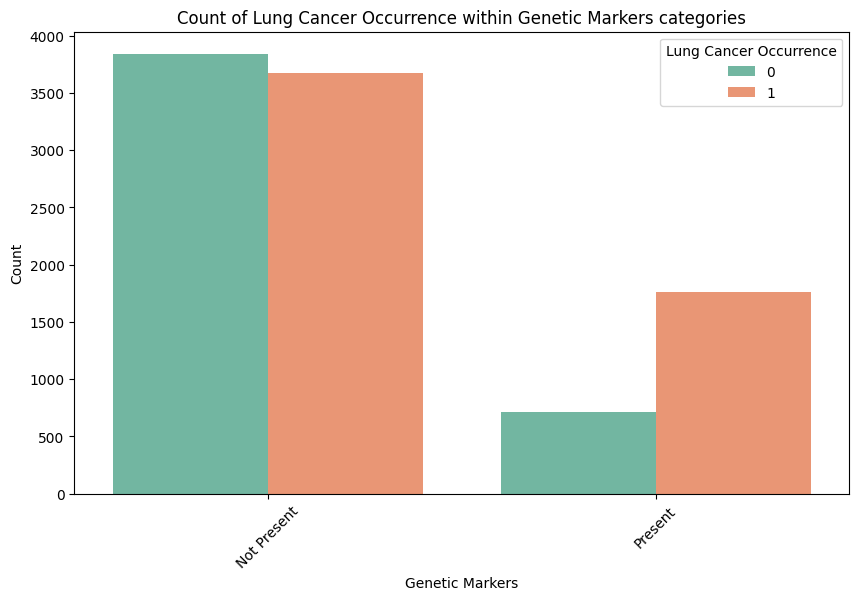

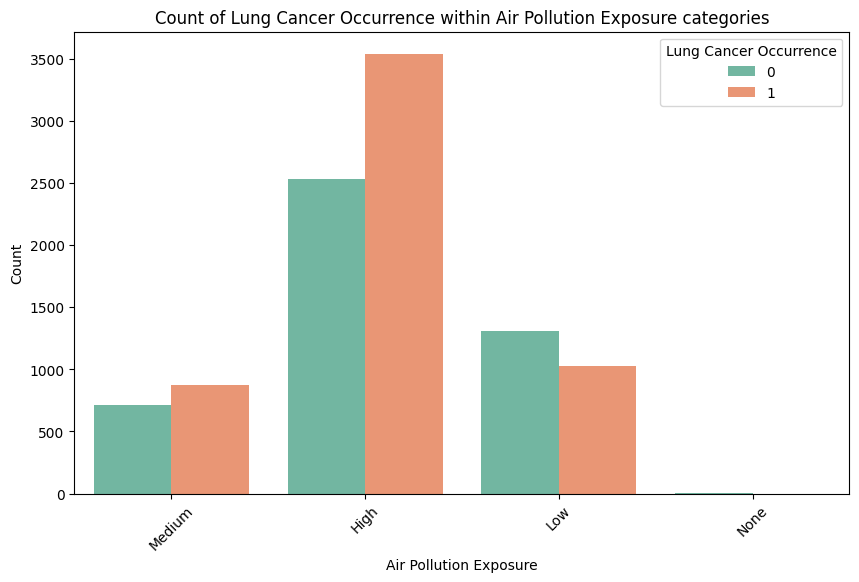

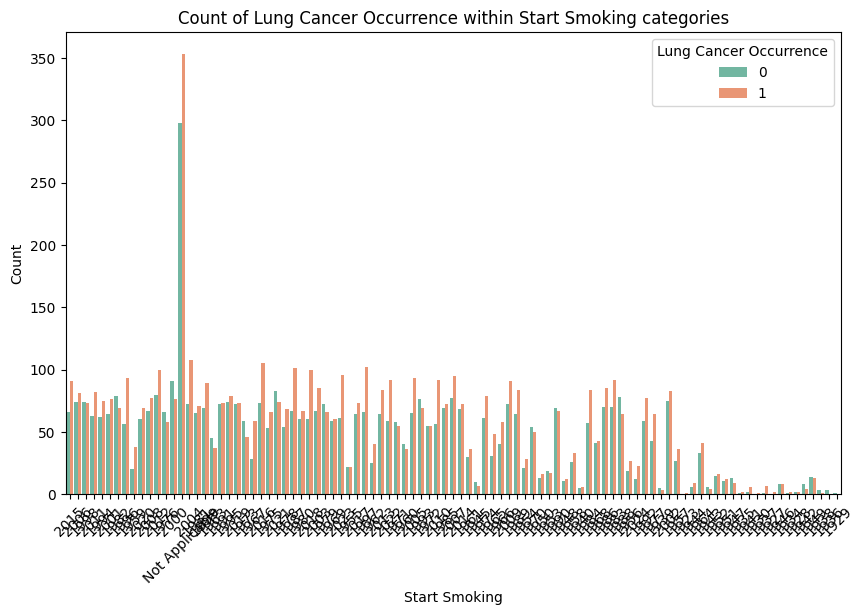

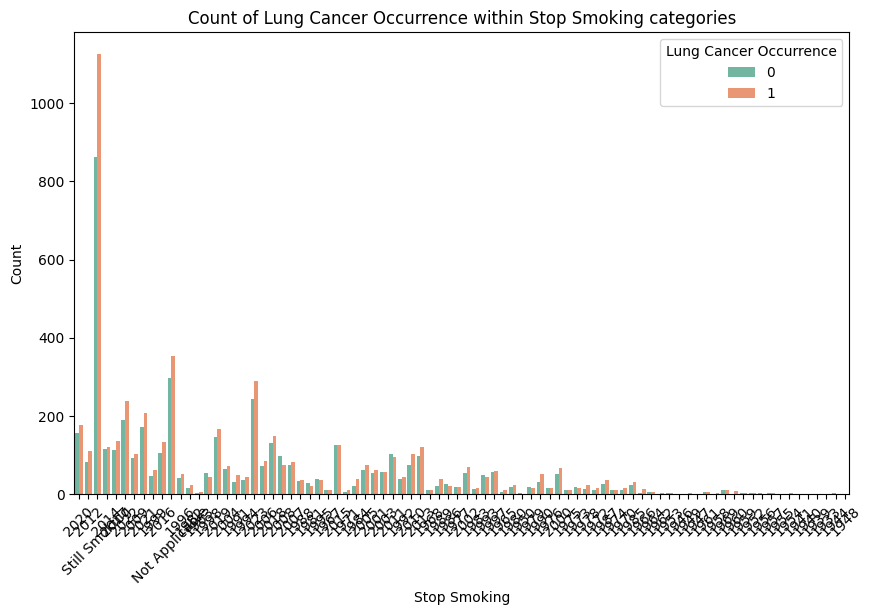

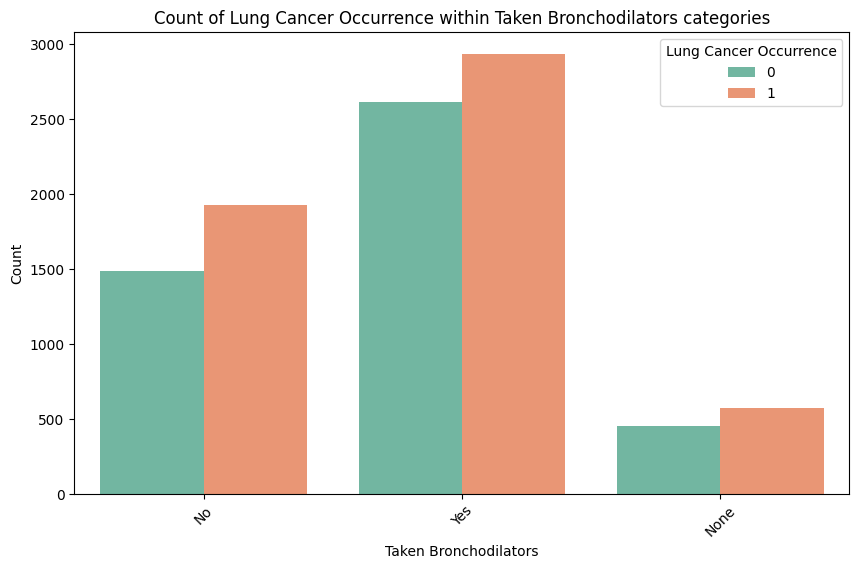

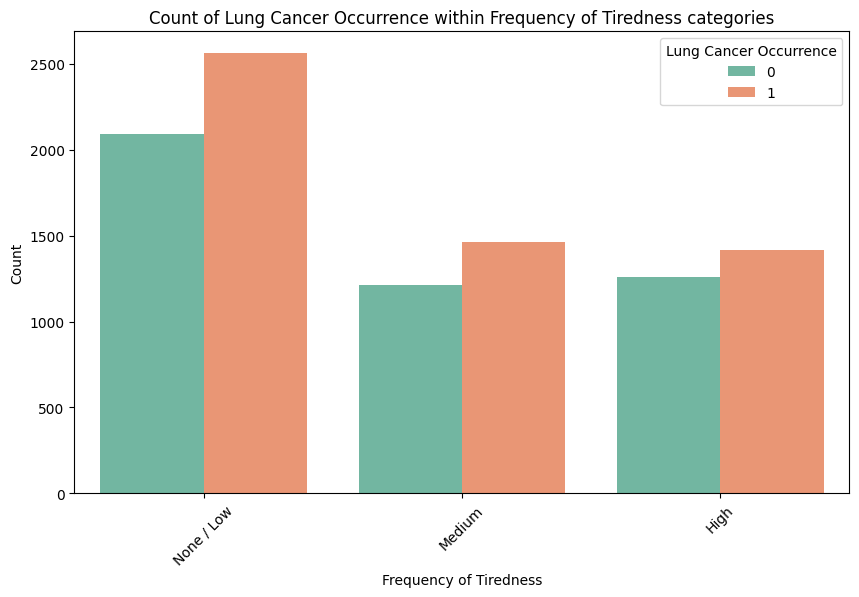

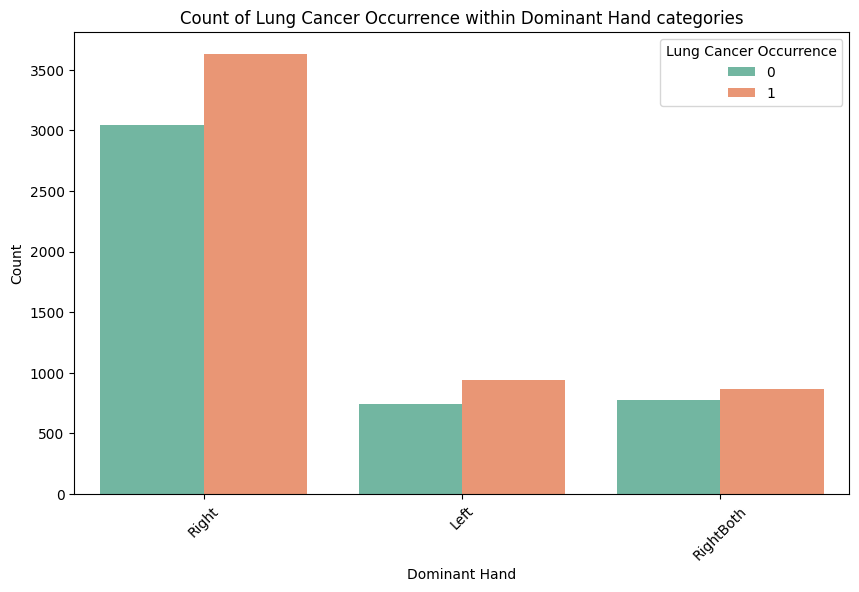

In [22]:

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_cleaned, x=col, hue=target, palette='Set2')
    plt.title(f'Count of {target} within {col} categories')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title=target)
    plt.show()

In [23]:
df_cleaned['Gender'] = df_cleaned['Gender'].replace({'MALE': 'Male', 'male': 'Male', 'FEMALE': 'Female', 'female': 'Female', 'NAN': 'Others'})

In [28]:
df_cleaned = df_cleaned.drop_duplicates()

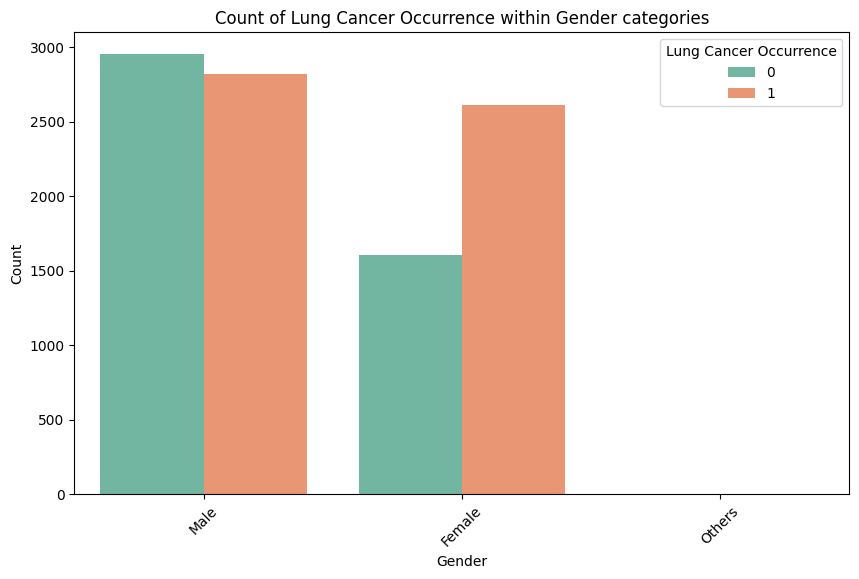

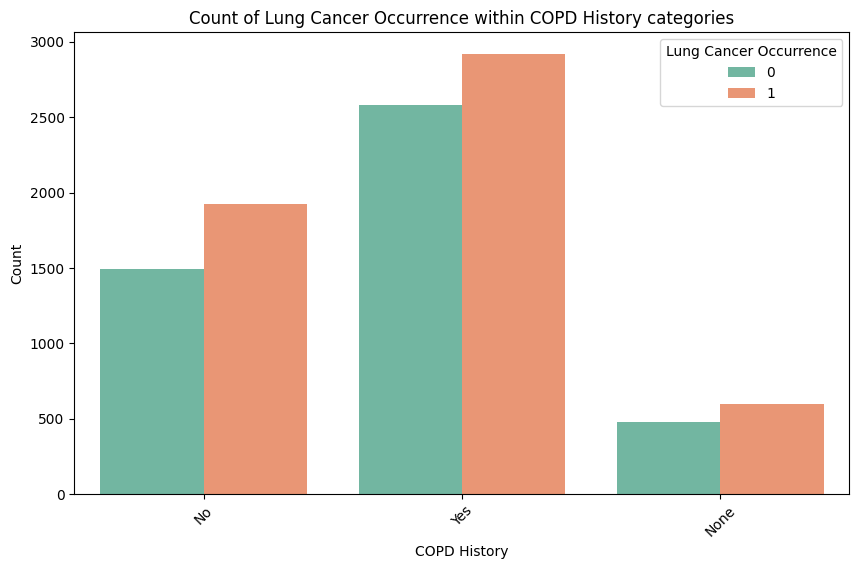

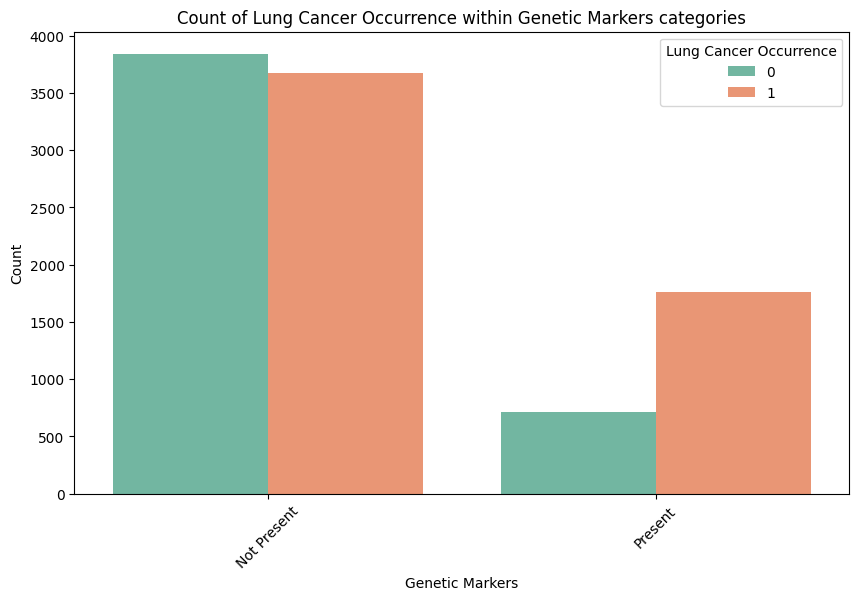

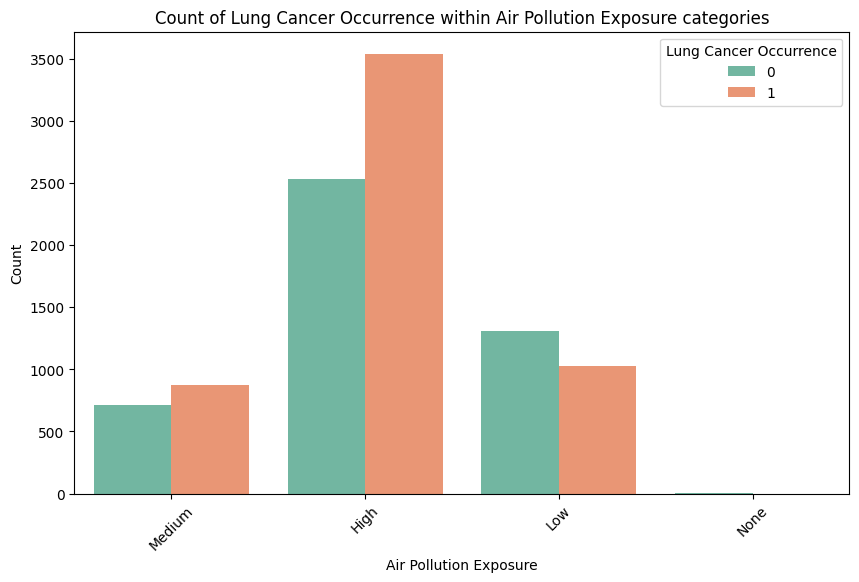

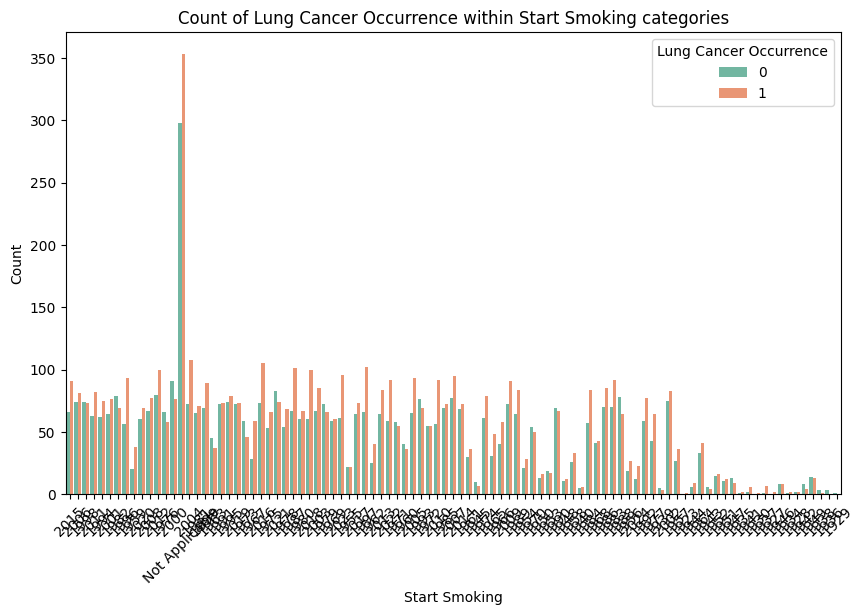

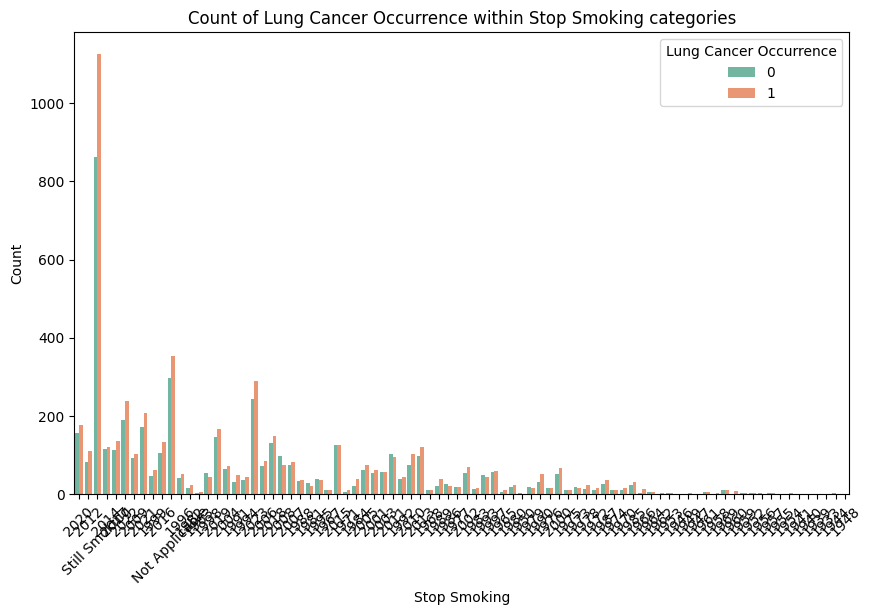

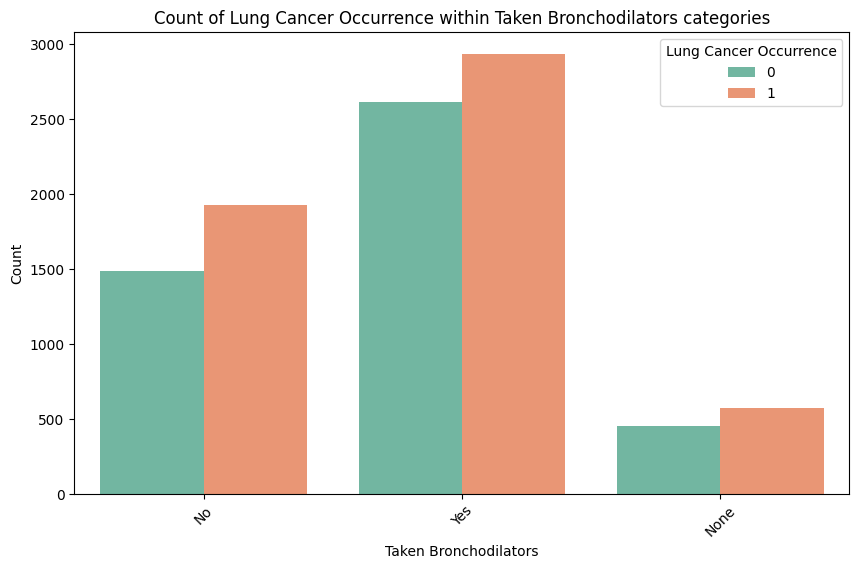

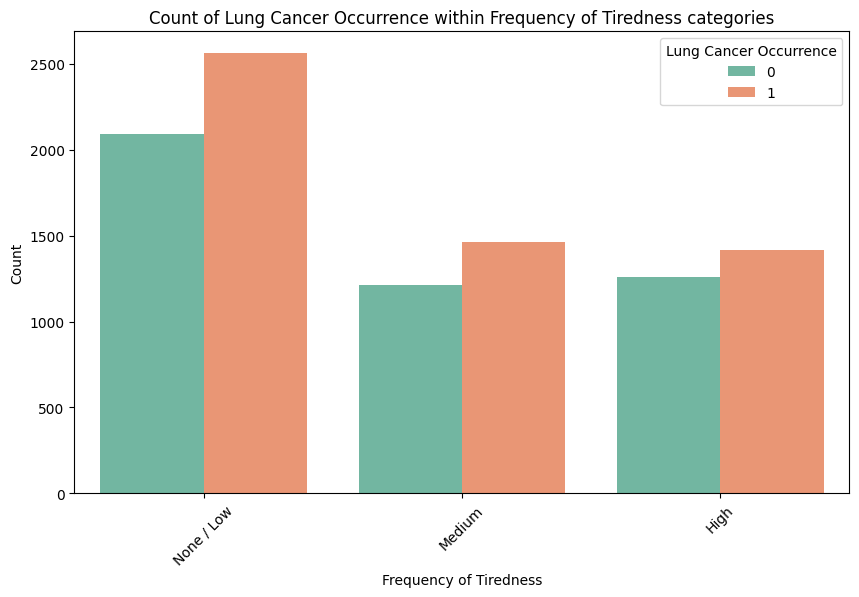

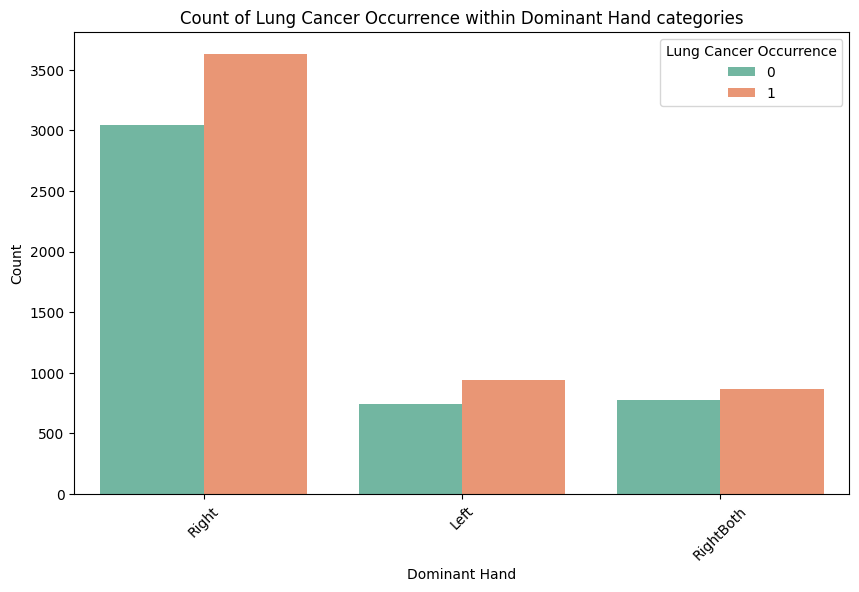

In [29]:
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df_cleaned, x=col, hue=target, palette='Set2')
    plt.title(f'Count of {target} within {col} categories')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title=target)
    plt.show()

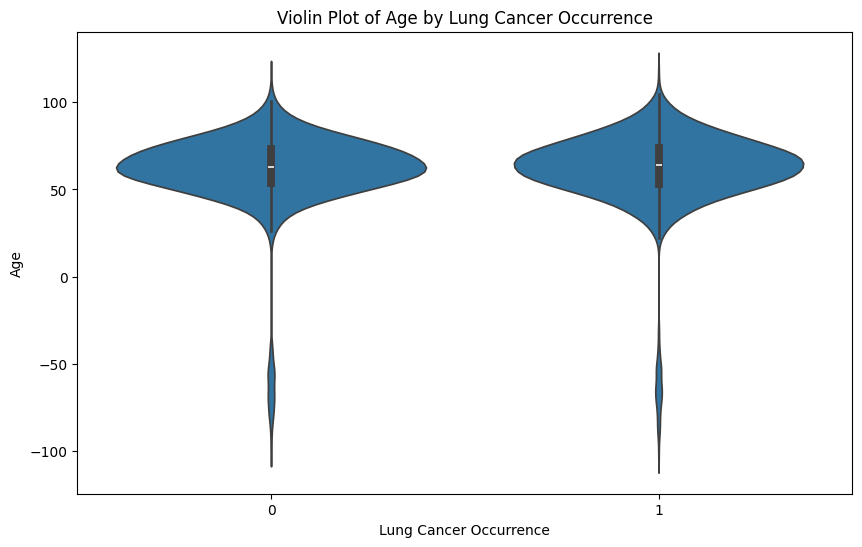

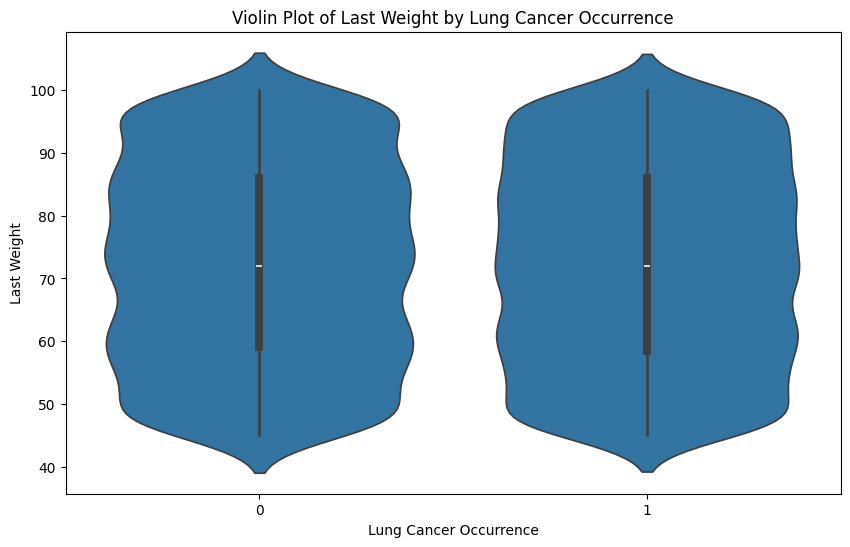

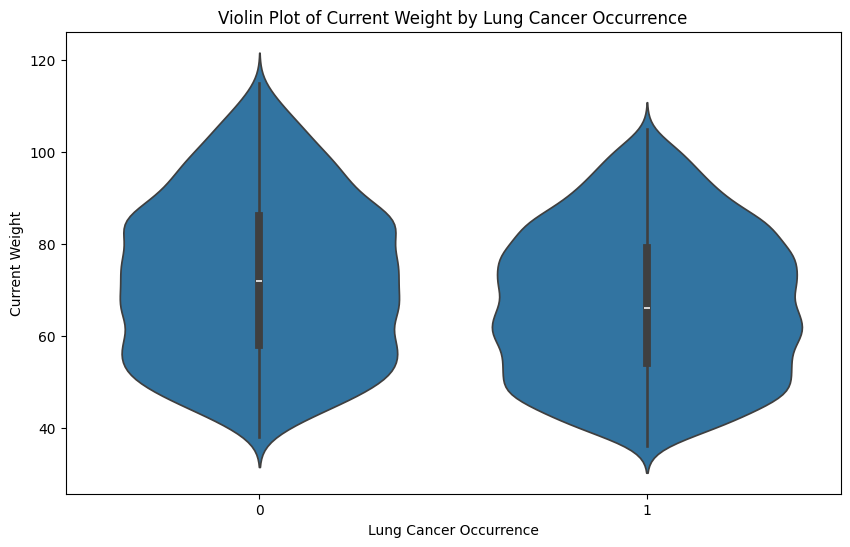

In [30]:
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=target, y=col, data=df_cleaned)
    plt.title(f'Violin Plot of {col} by {target}')
    plt.xlabel(target)
    plt.ylabel(col)
    plt.show()

<Figure size 1000x600 with 0 Axes>

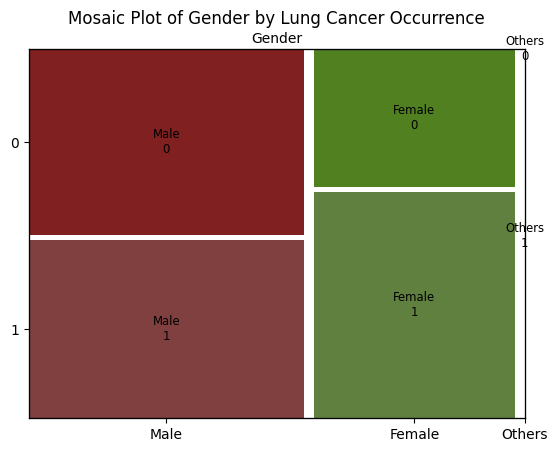

<Figure size 1000x600 with 0 Axes>

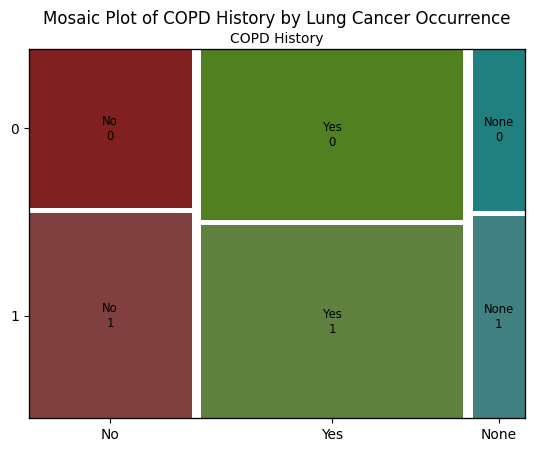

<Figure size 1000x600 with 0 Axes>

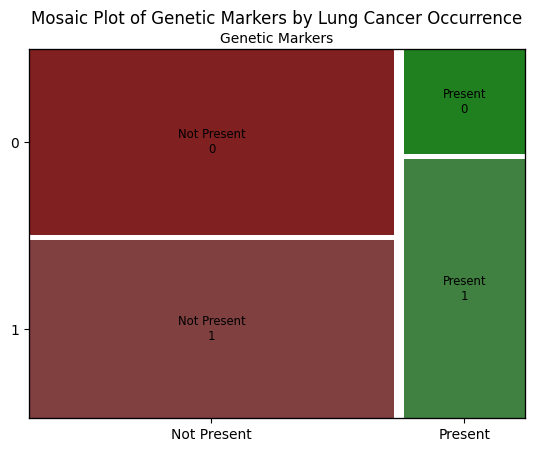

<Figure size 1000x600 with 0 Axes>

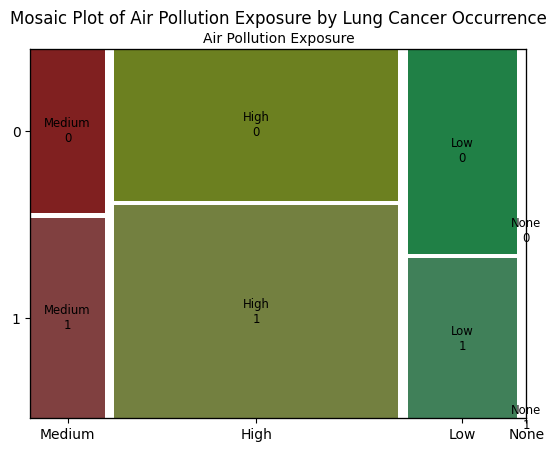

<Figure size 1000x600 with 0 Axes>

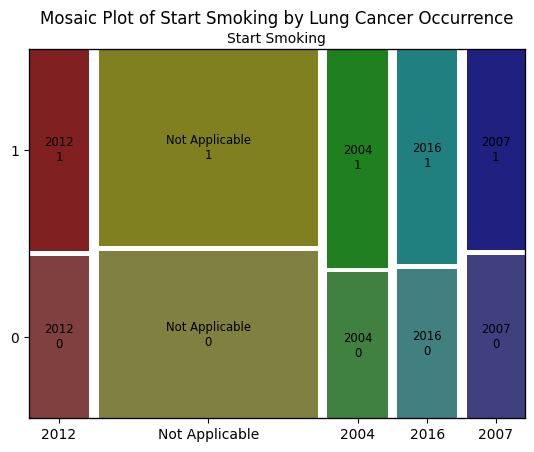

<Figure size 1000x600 with 0 Axes>

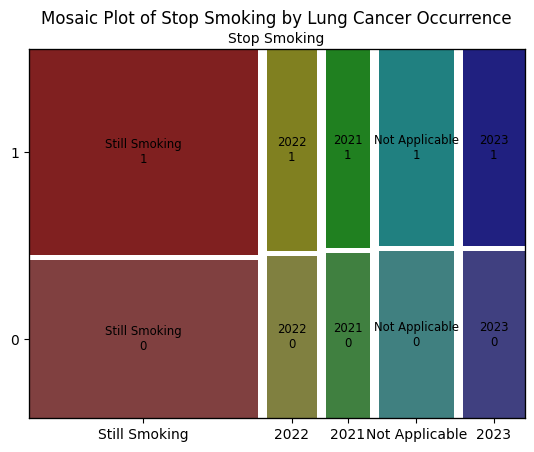

<Figure size 1000x600 with 0 Axes>

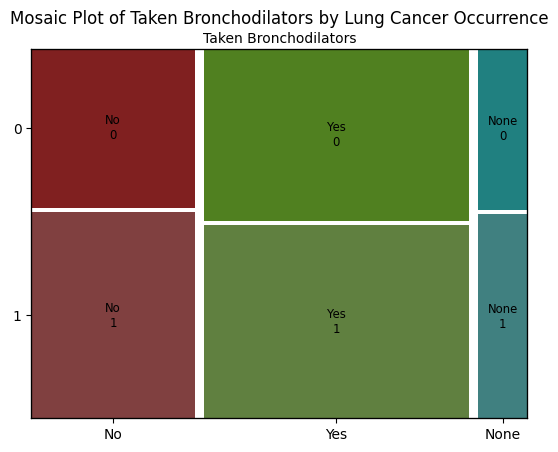

<Figure size 1000x600 with 0 Axes>

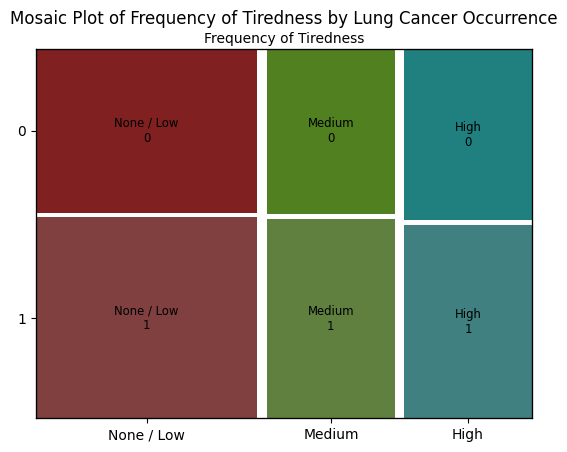

<Figure size 1000x600 with 0 Axes>

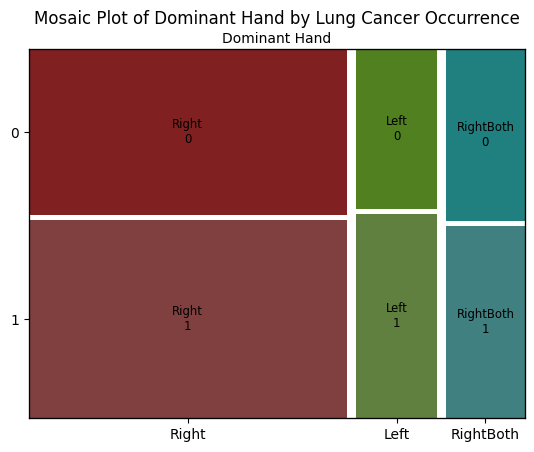

In [31]:
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    top_categories = df_cleaned[col].value_counts().nlargest(5).index
    filtered_data = df_cleaned[df_cleaned[col].isin(top_categories)]
    mosaic(filtered_data, [col, target], gap=0.02)
    plt.title(f'Mosaic Plot of {col} by {target}')
    plt.xlabel(col)
    plt.ylabel(target)
    plt.show()

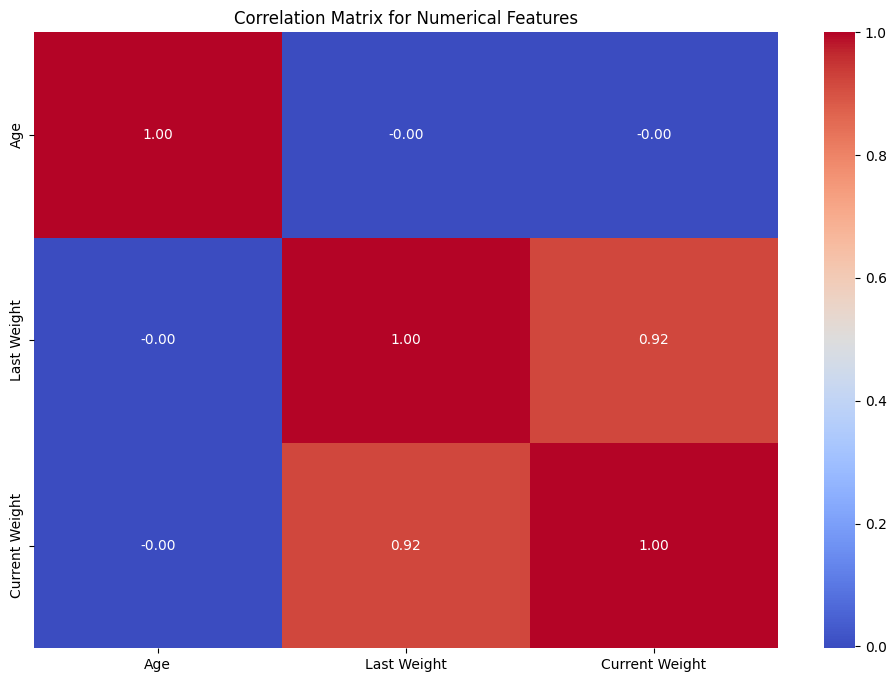

In [32]:
numerical_features = df_cleaned[numerical_cols]

corr_matrix = numerical_features.corr()

# Creating a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

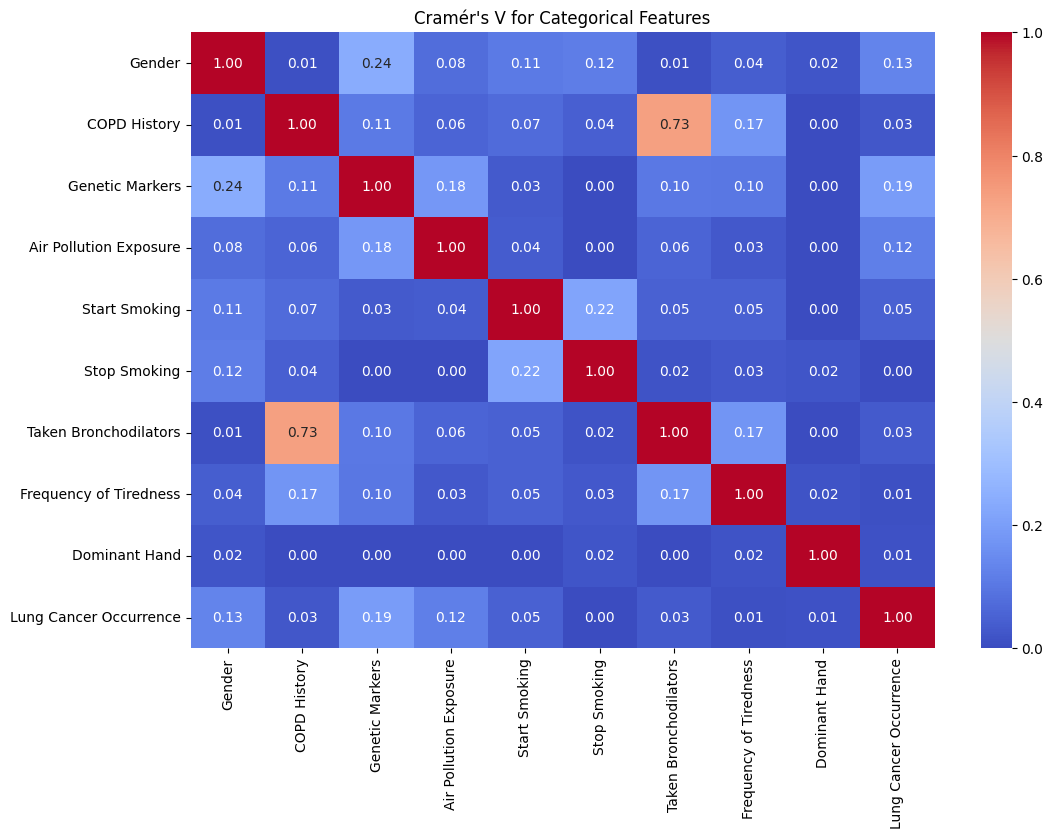

In [33]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum() #first sum call to sum across columns and give a series, which is then again summed up to get a value
    phi2 = chi2 / n # compute the chi^2 statistic here
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1)) # bias correction
    rcorr = r - ((r-1)**2)/(n-1) #row correction to adjust for bias
    kcorr = k - ((k-1)**2)/(n-1) # column correction to adjust for bias
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))) # finds the Cramer's V statistic

categorical_cols = categorical_cols.append(pd.Index([target]))

cramers_results = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        cramers_results.loc[col1, col2] = cramers_v(df_cleaned[col1], df_cleaned[col2])

# Converting the results to numeric values
cramers_results = cramers_results.apply(pd.to_numeric)

# Creating a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_results, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Cramér's V for Categorical Features")
plt.show()


In [34]:
def get_train_test_ds(column_to_remove=None):
  global df_cleaned
  if column_to_remove is not None:
    df_cleaned = df_cleaned.drop(column_to_remove, axis=1)
  X = df_cleaned.drop(target, axis=1)
  y = df_cleaned[target]


  categorical_cols = X.select_dtypes(include=['object', 'category']).columns

  encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

  X_encoded_categorical = encoder.fit_transform(X[categorical_cols])

  X_encoded_categorical = pd.DataFrame(X_encoded_categorical,
                                      columns=encoder.get_feature_names_out(categorical_cols))
  numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

  X_encoded = pd.concat([X[numerical_cols], X_encoded_categorical], axis=1)


  X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

  return X_train, X_test, y_train, y_test

In [35]:
def get_feature_importances(model):
  importances = model.feature_importances_

  feature_names = X_train.columns

  feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

  feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

  return feature_importances

In [36]:
X_train, X_test, y_train, y_test = get_train_test_ds()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
rf_params = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
dt_params = {'max_depth': [5, 10, 15]}

def get_best_estimator(estimator_name):
  best_estimator = None
  if estimator_name == 'RF':
    rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='accuracy')
    rf_grid.fit(X_train, y_train)
    best_estimator = rf_grid.best_estimator_
  else:
    dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=3, scoring='accuracy')
    dt_grid.fit(X_train, y_train)
    best_estimator = dt_grid.best_estimator_
  return best_estimator

def display_evaluation_metrics(model, modelname):
  predictions = model.predict(X_test)

  print(f'{modelname} classification report \n', classification_report(y_test, predictions))

  print(f'{modelname} confusion matrix \n', confusion_matrix(y_test, predictions))

In [38]:
def perform_iteration():
  rf_model = get_best_estimator('RF')
  dt_model = get_best_estimator('DT')

  display_evaluation_metrics(rf_model, 'Random Forest')
  display_evaluation_metrics(dt_model, 'Decision Tree')
  print(" **************************************************************************** \n\n")
  print('RF Feature importances ', get_feature_importances(rf_model))
  print('DT Feature importances ', get_feature_importances(dt_model))


In [47]:
perform_iteration()

Random Forest classification report 
               precision    recall  f1-score   support

           0       0.69      0.61      0.65       909
           1       0.70      0.77      0.74      1091

    accuracy                           0.70      2000
   macro avg       0.70      0.69      0.69      2000
weighted avg       0.70      0.70      0.70      2000

Random Forest confusion matrix 
 [[554 355]
 [250 841]]
Decision Tree classification report 
               precision    recall  f1-score   support

           0       0.65      0.56      0.60       909
           1       0.67      0.74      0.71      1091

    accuracy                           0.66      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.66      0.66      0.66      2000

Decision Tree confusion matrix 
 [[509 400]
 [279 812]]
 **************************************************************************** 


RF Feature importances                                Feature  Importance
2  

In [48]:
X_train, X_test, y_train, y_test = get_train_test_ds('Stop Smoking')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [49]:
perform_iteration()

Random Forest classification report 
               precision    recall  f1-score   support

           0       0.70      0.63      0.66       909
           1       0.71      0.78      0.74      1091

    accuracy                           0.71      2000
   macro avg       0.71      0.70      0.70      2000
weighted avg       0.71      0.71      0.71      2000

Random Forest confusion matrix 
 [[571 338]
 [245 846]]
Decision Tree classification report 
               precision    recall  f1-score   support

           0       0.66      0.56      0.61       909
           1       0.68      0.76      0.72      1091

    accuracy                           0.67      2000
   macro avg       0.67      0.66      0.66      2000
weighted avg       0.67      0.67      0.67      2000

Decision Tree confusion matrix 
 [[510 399]
 [257 834]]
 **************************************************************************** 


RF Feature importances                          Feature  Importance
2        

In [42]:
X_train, X_test, y_train, y_test = get_train_test_ds('Start Smoking')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [43]:
perform_iteration()

Random Forest classification report 
               precision    recall  f1-score   support

           0       0.69      0.61      0.65       909
           1       0.70      0.77      0.74      1091

    accuracy                           0.70      2000
   macro avg       0.70      0.69      0.69      2000
weighted avg       0.70      0.70      0.70      2000

Random Forest confusion matrix 
 [[554 355]
 [250 841]]
Decision Tree classification report 
               precision    recall  f1-score   support

           0       0.65      0.56      0.60       909
           1       0.67      0.74      0.71      1091

    accuracy                           0.66      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.66      0.66      0.66      2000

Decision Tree confusion matrix 
 [[509 400]
 [279 812]]
 **************************************************************************** 


RF Feature importances                                Feature  Importance
2  

In [50]:
df_cleaned.columns

Index(['Age', 'Gender', 'COPD History', 'Genetic Markers',
       'Air Pollution Exposure', 'Last Weight', 'Current Weight',
       'Start Smoking', 'Taken Bronchodilators', 'Frequency of Tiredness',
       'Dominant Hand', 'Lung Cancer Occurrence'],
      dtype='object')

In [52]:
df_cleaned.to_csv('/content/drive/MyDrive/Lung_cancer/dataset.csv', index=False)